In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error

def df_preview(df):
    for col in df.columns:
        print(col, "null count ::", df[col].isnull().sum(), "// mean ::", df[col].mean())

def df_col_distplot(df):
    for col in df.columns:
        print(col, "plot")
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()

def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

In [2]:
## concat_df: train, test 를 합친 dataframe

concat_df = pd.concat([train, test])
concat_df.shape

## feature_df: target 을 제외한 dataframe

target_cols = ['hhb', 'hbo2', 'ca', 'na']
feature_df = concat_df.drop(target_cols, axis=1)

In [3]:
feature_dst = feature_df.filter(regex='_dst$', axis=1)
feature_src = feature_df.filter(regex='_src$', axis=1)

In [4]:
## KNNImputer 를 사용함

from sklearn.impute import KNNImputer

imputer_n30 = KNNImputer(n_neighbors=30)

In [5]:
imputed_30_df = imputer_n30.fit_transform(feature_dst)

## impute 결과가 list 로 나오기 때문에 dataframe 으로 바꿔주는 작업
imputed_30_df = pd.DataFrame(imputed_30_df, columns=feature_dst.columns, index=list(feature_dst.index.values))

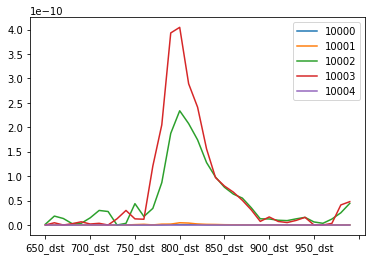

In [6]:
target_cols = ['hhb', 'hbo2', 'ca', 'na']

for col_name in target_cols:
    imputed_30_df[col_name] = concat_df[col_name]

imputed_train_30 = imputed_30_df[imputed_30_df['hhb'].notnull()]
imputed_test_30 = imputed_30_df[imputed_30_df['hhb'].isnull()]

imputed_test_30.filter(regex='_dst$', axis=1).head().T.plot()

In [7]:
feature_df.update(imputed_30_df)
feature_df

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,
0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,...,9.727870e-19,3.527371e-18,1.130983e-18,6.455564e-19,9.663751e-19,0.000000e+00,7.425205e-19,1.067504e-18,5.998949e-18,4.378513e-17
1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,...,2.647633e-09,1.682896e-10,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,2.799156e-10,9.710091e-09,9.192786e-11
2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,...,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,1.290044e-17
3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,...,1.274876e-10,6.118947e-11,9.433465e-11,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,7.685807e-11,4.088921e-10,3.029613e-10
4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,...,0.000000e+00,2.555342e-14,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,2.004864e-14,1.330237e-13,2.683695e-13,1.069513e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,15,0.04334,0.03279,0.05853,0.04070,0.07704,0.07859,0.06168,0.08903,0.08833,...,7.889599e-13,5.487817e-13,4.903209e-13,1.365078e-12,7.929664e-13,0.000000e+00,0.000000e+00,1.472213e-13,1.479745e-12,5.391520e-12
19996,25,0.00020,0.02009,0.01726,0.03816,0.08300,0.08681,0.15300,0.18099,0.24377,...,1.240848e-17,6.258180e-18,8.693704e-20,1.259932e-18,4.514449e-18,5.133327e-19,9.128300e-19,5.952527e-19,3.928314e-18,2.586781e-17
19997,15,0.00000,0.00000,0.00120,0.00000,0.04347,0.14882,0.40883,0.80365,1.01179,...,0.000000e+00,2.078241e-15,0.000000e+00,2.610282e-14,7.789652e-15,7.917686e-16,1.271388e-15,1.436617e-15,0.000000e+00,1.743751e-13


In [8]:
# feature_df
for col in feature_dst.columns:
    feature_df[col] = feature_df[col] * (feature_df['rho'] ** 2)

In [9]:
gap_feature_names=[]
for i in range(650, 1000, 10):
    gap_feature_names.append(str(i) + '_gap')

In [10]:
## src - dst gap 추가

dst_list = feature_dst.columns
src_list = feature_src.columns

gap_df=pd.DataFrame(np.array(feature_df[src_list]) - np.array(feature_df[dst_list]), columns=gap_feature_names, index=feature_df.index)

feature_df=pd.concat((feature_df, gap_df), axis=1)

In [11]:
epsilon=1e-10

for dst_col, src_col in zip(dst_list, src_list):
    dst_val=feature_df[dst_col]
    src_val=feature_df[src_col] + epsilon
    delta_ratio = dst_val / src_val
    feature_df[dst_col + '_' + src_col + '_ratio'] = delta_ratio

In [12]:
from tqdm import tqdm
alpha_real=feature_df[dst_list]
alpha_imag=feature_df[dst_list]

for i in tqdm(alpha_real.index):
    alpha_real.loc[i]=alpha_real.loc[i] - alpha_real.loc[i].mean()
    alpha_imag.loc[i]=alpha_imag.loc[i] - alpha_real.loc[i].mean()
    
    alpha_real.loc[i] = np.fft.fft(alpha_real.loc[i], norm='ortho').real
    alpha_imag.loc[i] = np.fft.fft(alpha_imag.loc[i], norm='ortho').imag
    
real_part=[]
imag_part=[]

for col in dst_list:
    real_part.append(col + '_fft_real')
    imag_part.append(col + '_fft_imag')
    
alpha_real.columns=real_part
alpha_imag.columns=imag_part
alpha = pd.concat((alpha_real, alpha_imag), axis=1)

100%|██████████| 20000/20000 [00:45<00:00, 439.77it/s]


In [13]:
feature_df=pd.concat((feature_df, alpha), axis=1)

In [14]:
no_src_df = feature_df.drop(columns=src_list)

In [15]:
target_cols = ['hhb', 'hbo2', 'ca', 'na']

for col_name in target_cols:
    no_src_df[col_name] = concat_df[col_name]

no_src_df_train = no_src_df[no_src_df['hhb'].notnull()]
no_src_df_test = no_src_df[no_src_df['hhb'].isnull()]

In [16]:
dont_need_scale_cols = ['rho', 'hhb', 'hbo2', 'ca', 'na']
droped_df = no_src_df.drop(dont_need_scale_cols, axis=1)

In [17]:
std_scaler = StandardScaler()
std_scaler.fit(droped_df)
scaled_feature = std_scaler.transform(droped_df)
scaled_feature = pd.DataFrame(scaled_feature, columns=droped_df.columns, index=list(droped_df.index.values))

In [18]:
for col_name in dont_need_scale_cols:
    scaled_feature[col_name] = concat_df[col_name]

scaled_train = scaled_feature[scaled_feature['hhb'].notnull()]
scaled_test = scaled_feature[scaled_feature['hhb'].isnull()]

In [19]:
from sklearn.model_selection import KFold
fold_num = 10
folds = KFold(n_splits = fold_num, shuffle = True, random_state = 551)

In [20]:
scaled_train

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,950_dst_fft_imag,960_dst_fft_imag,970_dst_fft_imag,980_dst_fft_imag,990_dst_fft_imag,rho,hhb,hbo2,ca,na
0,-0.029544,-0.032011,-0.045944,-0.069772,-0.128891,-0.076268,-0.090149,-0.124483,-0.103840,-0.122510,...,-0.022948,0.239254,-0.035308,0.118846,0.108163,25,5.59,4.32,8.92,4.29
1,-0.029544,-0.032011,-0.045944,2.785190,2.527859,-0.076268,-0.090150,-0.124483,0.073747,-0.122510,...,4.195279,7.026418,1.015247,-10.064543,-11.702443,10,0.00,2.83,7.25,4.64
2,-0.029544,-0.032011,-0.045944,-0.069773,-0.128893,-0.076268,-0.090149,-0.124483,-0.103840,-0.122510,...,-0.022949,0.239254,-0.035308,0.118846,0.108163,25,10.64,3.00,8.40,5.16
3,0.091805,0.059657,0.412409,0.060517,0.358649,0.286229,-0.084300,0.710096,0.856579,0.480018,...,1.294231,-1.482777,1.306798,-1.501726,0.696193,10,5.67,4.01,5.05,4.35
4,-0.029221,-0.031961,-0.045944,-0.066061,-0.128893,-0.076268,-0.088391,-0.124483,-0.103840,-0.122126,...,-0.023646,0.237759,-0.035648,0.118178,0.107902,15,11.97,4.41,10.78,2.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.029526,-0.031883,-0.045944,-0.069773,-0.128796,-0.075393,-0.089965,-0.123634,-0.103840,-0.122307,...,-0.022747,0.238930,-0.035126,0.118691,0.108320,15,12.68,4.11,12.31,0.10
9996,-0.029544,-0.032010,-0.045944,-0.069771,-0.128893,-0.076268,-0.090149,-0.124481,-0.103840,-0.122510,...,-0.022958,0.239249,-0.035314,0.118846,0.108160,20,8.46,4.11,10.46,3.12
9997,-0.007799,-0.032011,0.136334,0.125374,0.135047,-0.076268,-0.090150,-0.071045,-0.042133,-0.095482,...,0.179868,-0.295161,0.156187,-0.168894,0.100969,10,9.84,3.20,10.45,2.06
9998,-0.028445,-0.031664,-0.045649,-0.067097,-0.109617,-0.076268,-0.090150,-0.122240,-0.103840,-0.121227,...,-0.033869,0.219569,-0.038321,0.111799,0.106024,15,6.38,4.06,11.28,4.03


In [21]:
import lightgbm as lgb

feature_col = scaled_train.drop(['hhb', 'hbo2', 'ca', 'na'], axis=1).columns
target_col_list = ['hhb', 'hbo2', 'ca', 'na']
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

submission_stack_df = pd.read_csv('../data/sample_submission.csv', index_col='id')
train_stack_df = pd.DataFrame(index=list(scaled_train[feature_col].index.values))

train_check_df = pd.DataFrame(columns=target_col_list, index=list(scaled_train[feature_col].index.values))
train_check_df = train_check_df.fillna(0)

for target_col in target_col_list:
    print("target_col :: ",target_col)
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(scaled_train)):
        x_data = scaled_train[feature_col]
        y_data = scaled_train[target_col]

        train_X, train_y = x_data.iloc[trn_idx], y_data.iloc[trn_idx] 
        valid_X, valid_y = x_data.iloc[val_idx], y_data.iloc[val_idx]

        train_ds = lgb.Dataset(train_X, label=train_y)
        valid_ds = lgb.Dataset(valid_X, label=valid_y)

        params = {
            'objective':'regression', 
            'n_estimators': 10000,
            'metric': 'regression_l1',
            'boosting': 'dart',
            'learning_rate': 0.1
        }

        model = lgb.train(
            params=params, 
            train_set=train_ds, 
            valid_sets=valid_ds, 
            verbose_eval=10000, 
            early_stopping_rounds=20 
        )

        test_x = scaled_test[feature_col]
        test_pred = model.predict(test_x)

        train_check_pred = model.predict(x_data)


        submission[target_col] = submission[target_col] + test_pred
        train_check_df[target_col] = train_check_df[target_col] + train_check_pred

        submission_stack_df[target_col+"_"+str(n_fold)] = test_pred
        train_stack_df[target_col+"_"+str(n_fold)] = train_check_pred

target_col ::  hhb
[10000]	valid_0's l1: 0.711009
[10000]	valid_0's l1: 0.688838
[10000]	valid_0's l1: 0.686485
[10000]	valid_0's l1: 0.711272
[10000]	valid_0's l1: 0.715887
[10000]	valid_0's l1: 0.714529
[10000]	valid_0's l1: 0.679139
[10000]	valid_0's l1: 0.698361
[10000]	valid_0's l1: 0.698291
[10000]	valid_0's l1: 0.704664
target_col ::  hbo2
[10000]	valid_0's l1: 0.525814
[10000]	valid_0's l1: 0.549003
[10000]	valid_0's l1: 0.532294
[10000]	valid_0's l1: 0.539032
[10000]	valid_0's l1: 0.553565
[10000]	valid_0's l1: 0.525736
[10000]	valid_0's l1: 0.519912
[10000]	valid_0's l1: 0.531041
[10000]	valid_0's l1: 0.519794
[10000]	valid_0's l1: 0.53017
target_col ::  ca
[10000]	valid_0's l1: 1.6991
[10000]	valid_0's l1: 1.67497
[10000]	valid_0's l1: 1.76013
[10000]	valid_0's l1: 1.76801
[10000]	valid_0's l1: 1.71406
[10000]	valid_0's l1: 1.69157
[10000]	valid_0's l1: 1.75491
[10000]	valid_0's l1: 1.69803
[10000]	valid_0's l1: 1.65475
[10000]	valid_0's l1: 1.6284
target_col ::  na
[10000]	

In [23]:
save_train_check_df = train_check_df
save_submission = submission

train_check_df_output = train_check_df / fold_num
submission_output = submission / fold_num

In [24]:
submission_output

,hhb,hbo2,ca,na
id,,,,
10000,9.227117,4.332003,8.781297,2.540571
10001,6.938280,2.980425,9.233365,2.894403
10002,8.864495,5.329897,10.678165,3.940262
10003,7.922287,4.279020,10.368764,4.230413
10004,6.514684,3.224960,9.093954,3.992723
...,...,...,...,...
19995,3.783306,4.402765,11.504505,3.769453
19996,10.660814,3.114412,6.131124,2.324868
19997,7.203789,3.964187,8.805434,3.767140


In [25]:
target_col_list = ['hhb', 'hbo2', 'ca', 'na']

res = rmse(train_check_df_output, scaled_train[target_col_list])
res

0.20527207774119344

In [26]:
from sklearn.linear_model import Lasso

target_col_list = ['hhb', 'hbo2', 'ca', 'na']
train_stack_df_output = pd.DataFrame(index=list(scaled_train[feature_col].index.values))

for target_col in target_col_list:
    x_data = train_stack_df.filter(regex=target_col, axis=1)
    y_data = scaled_train[target_col]

    meta_model_lasso = Lasso(alpha=0.0005)
    meta_model_lasso.fit(x_data, y_data) 

    train_check_pred = meta_model_lasso.predict(x_data)
    train_stack_df_output[target_col] = train_check_pred

    submission_test_data = submission_stack_df.filter(regex=target_col+'_', axis=1)
    submission[target_col] = meta_model_lasso.predict(submission_test_data)

train_res = rmse(train_stack_df_output, scaled_train[target_col_list])
print(train_res)
print(submission)

0.14052312717898782
             hhb      hbo2         ca        na
id                                             
10000   9.273108  4.360039   8.770844  2.495794
10001   6.932554  2.906339   9.248919  2.882471
10002   8.871092  5.433783  10.822669  4.032055
10003   7.933947  4.302852  10.491366  4.352173
10004   6.471729  3.169484   9.108522  4.092610
...          ...       ...        ...       ...
19995   3.715076  4.437298  11.719377  3.844625
19996  10.701616  3.045583   5.902224  2.258670
19997   7.210135  3.964871   8.792209  3.845347
19998  13.156402  4.416782  10.188668  3.669940
19999   4.243064  5.076322  11.923902  1.984979

[10000 rows x 4 columns]


In [27]:
import time
filename = time.strftime('%Y-%m-%d-%H_%M_%S')+'submission.csv'

train_stack_df.to_csv(time.strftime('%Y-%m-%d-%H_%M_%S')+'train_stack_df.csv', index=True)
train_stack_df_output.to_csv(time.strftime('%Y-%m-%d-%H_%M_%S')+'train_stack_df_output.csv', index=True)
submission.to_csv(time.strftime('%Y-%m-%d-%H_%M_%S')+'submission.csv', index=True)
submission_stack_df.to_csv(time.strftime('%Y-%m-%d-%H_%M_%S')+'submission_stack_df.csv', index=True)
submission_output.to_csv(time.strftime('%Y-%m-%d-%H_%M_%S')+'submission_output.csv', index=True)